# One-Hot Fully-Connected Model

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [2]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [3]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import wandb

`wandb` log in:

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Google drive access

In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [6]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text decoder to be used (instantianted) in the notebook:

In [7]:
notebook_model = avm.LitOneHotFC
notebook_datamodule = avm.OneHotCharDataModule
# one_hot_decoding (ints_to_string) for one-hot (embedded text)
notebook_encoder = avm.one_hot_encoding 
notebook_decoder = avm.one_hot_decoding 
notebook_wandb_callback = avm.WandbTextCallback

Copy data to cwd for speed.

In [8]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [9]:
# GPU. Save availability to is_cuda_available.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  is_cuda_available = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  is_cuda_available = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
num_processors = cpu_count()

GPU
--------------------------------------------------
 Mon Dec 13 18:35:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [10]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_one_hot_linear


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [11]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [12]:
print(train_data_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [13]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [14]:
model_args_dic = {'seq_len': SEQ_LEN,
                  'tokens': tokens_df,
                  'fc_dims': None,
                  'nonlinearity': False
                  }
data_args_dic = {'seq_len': SEQ_LEN,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'num_workers': num_processors,
                 'batch_size': 32,
                 'pin_memory': is_cuda_available,
                 'persistent_workers': True
                 }

Small test run.

In [15]:
small_data_module = notebook_datamodule(**{**data_args_dic, **{'sample_size': .25}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, tokens_df)
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dic)
print('Model layers:', small_model.layers)
small_preds, small_losses = small_model.scores_losses(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text:                                                                                the light deflection and the anomaly near the sun
len: 128
source: True
text:                                                                  commonsense for generative multi - hop question answering tasks
len: 128
source: False
text:                non - destructive quality analysis of indian gujarat - 17 oryza sativa ssp indica ( rice ) using image processing
len: 128
source: True
Model layers: ModuleList(
  (0): Linear(in_features=8832, out_features=1, bias=True)
)

preds shape: torch.Size([32])

actual loss: 0.7296310067176819

expected approx loss 0.6931471805599453


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [16]:
small_trainer = Trainer(gpus=-1,max_epochs=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_0b48d6be-6ec7-4535-ac65-ec0e9d6be49f.ckpt


Suggested lr: 2.7542287033381663e-06


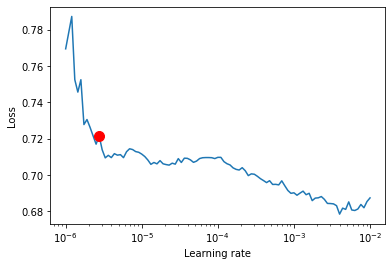

In [17]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=1e-2)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
print(f'Suggested lr: {small_trainer_lr_finder.suggestion()}')

In [18]:
small_trainer.fit(small_model, datamodule=small_data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | train_acc               | Accuracy         | 0     
1 | val_acc                 | Accuracy         | 0     
2 | test_acc                | Accuracy         | 0     
3 | train_auc_roc           | AUROC            | 0     
4 | val_auc_roc             | AUROC            | 0     
5 | test_auc_roc            | AUROC            | 0     
6 | train_average_precision | AveragePrecision | 0     
7 | val_average_precision   | AveragePrecision | 0     
8 | test_average_precision  | AveragePrecision | 0     
9 |

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `fixed_hyper_dic`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `fixed_hyper_dic` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [19]:
fixed_hyper_dic = {**model_args_dic, **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['early_terminate'] = {'type': 'hyperband',
                                    'min_iter': 3
                                   }
sweep_config['metric'] = {'name': 'best_val_loss',
                           'goal': 'minimize'
                           }
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'max': np.log(1e-2).item(),
                                      'min': np.log(1e-4).item()
                                      },                          
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `fixed_hyper_dic` for logging purposes.

In [20]:
# Setting 'batch_size' in data_args_dic controls the batch size, while setting
# this key in fixed_hyper_dic just lets wandb track this hyperparameter.
data_args_dic['batch_size'] = fixed_hyper_dic['batch_size'] = 4096

# Set max_epochs in a dict, along with any other optional trainer kwargs.
trainer_dic = {'max_epochs': 16,
               }

# Merge trainer_dic into fixed_hyper_dic for logging purposes.
fixed_hyper_dic = {**fixed_hyper_dic, **trainer_dic}

def sweep_iteration():
    group_str = 'linear_models'
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**data_args_dic)
        config = wandb.config
        # Merge config into remaining parameters.
        config = {**fixed_hyper_dic, **config}
        model = notebook_model(**config)
        # Taking random samples from the validation set for callback visualization.
        val_sample_module = notebook_datamodule(**{**data_args_dic, **{'sample_size': 512}})
        val_sample_module.setup()
        val_sample  = next(iter(val_sample_module.val_dataloader()))
        # Overwrite the random run names chosen by wandb.
        run.name = f"lr_{config['lr']}_no_hiddens"
        trainer = Trainer(
            logger=WandbLogger(),
            gpus=-1 if is_cuda_available else 0,
            log_every_n_steps=5,
            callbacks=[notebook_wandb_callback(val_sample=val_sample,
                                               decoder_fn=notebook_decoder,
                                               translation_data=tokens_df,
                                               labels=('arxiv', 'vixra')),
                       EarlyStopping(monitor='val_loss')
                       ],
            num_sanity_val_steps=-1,
            **trainer_dic
            )
        trainer.fit(model, datamodule=data)

In [21]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: fo2ipb2m
Sweep URL: https://wandb.ai/garrett361/balanced_title_one_hot_linear/sweeps/fo2ipb2m


In [22]:
wandb.agent(sweep_id, function=sweep_iteration, count=5)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: xvepvslw with config:
wandb: 	lr: 0.004339533794514039
wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.4885149598121643
Validation Loss: 0.7178062200546265
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.4885149598121643
Validation Loss: 0.7178062200546265


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6200587749481201
Validation Loss: 0.8118760585784912


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6769497990608215
Validation Loss: 0.6758158802986145
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6769497990608215
Validation Loss: 0.6758158802986145


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.671875
Validation Loss: 0.5993714332580566


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6712072491645813
Validation Loss: 0.592937707901001


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.7017895579338074
Validation Loss: 0.5882750749588013
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.7017895579338074
Validation Loss: 0.5882750749588013


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6927083134651184
Validation Loss: 0.5782194137573242


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6931089758872986
Validation Loss: 0.5769466161727905


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6979166865348816
Validation Loss: 0.5754952430725098


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6952457427978516
Validation Loss: 0.5748167037963867


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 11
Validation accuracy: 0.7020566463470459
Validation Loss: 0.5748234391212463


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▆▆▆████████
best_val_loss,█▆▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
global_step,▁▂▂▃▃▄▄▅▆▆▇▇█
train_acc,▁▄▆▆▇███████
train_auc_roc,▁▃▅▆▇▇██████
train_average_precision,▁▃▅▆▇▇██████
train_loss,█▄▂▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
val_acc,▁▆▅▅█▇▇█▇█▇█
val_auc_roc,▁▄▅▆▇▇▇█████


Run xvepvslw errored: ValueError('signal only works in main thread')
wandb: ERROR Run xvepvslw errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: 4x3r6tv4 with config:
wandb: 	lr: 0.00887210492685829


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5737179517745972
Validation Loss: 0.7115197777748108
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5737179517745972
Validation Loss: 0.7115197777748108


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.5782585740089417
Validation Loss: 1.381569743156433


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6204593777656555
Validation Loss: 0.8767606019973755


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6870993375778198
Validation Loss: 0.6759248971939087
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6870993375778198
Validation Loss: 0.6759248971939087


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

best_val_acc,▁▁▄█
best_val_loss,███▁
epoch,▁▁▃▃▆▆██
global_step,▁▃▄▆█
train_acc,▁▅▅█
train_auc_roc,▁▄▅█
train_average_precision,▁▅▅█
train_loss,█▄▂▁
trainer/global_step,▁▁▁▃▃▃▆▆▆██
val_acc,▁▃▅█
val_auc_roc,▁▃▆█


wandb: Agent Starting Run: ez0meosp with config:
wandb: 	lr: 0.00355723904641079


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5036057829856873
Validation Loss: 0.6948013305664062
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5036057829856873
Validation Loss: 0.6948013305664062


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.5838675498962402
Validation Loss: 1.0441973209381104


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6147168874740601
Validation Loss: 0.8080852031707764


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6805555820465088
Validation Loss: 0.6707125902175903
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6805555820465088
Validation Loss: 0.6707125902175903


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6947115659713745
Validation Loss: 0.610534131526947
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6947115659713745
Validation Loss: 0.610534131526947


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6965811848640442
Validation Loss: 0.5845295190811157
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6965811848640442
Validation Loss: 0.5845295190811157


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6868322491645813
Validation Loss: 0.5812348127365112


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.7029914259910583
Validation Loss: 0.5781633853912354
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.7029914259910583
Validation Loss: 0.5781633853912354


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.7000533938407898
Validation Loss: 0.5773289203643799


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.7017895579338074
Validation Loss: 0.5761125683784485


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 98
Epoch: 10
Validation accuracy: 0.7035256624221802
Validation Loss: 0.5748894810676575
Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.7035256624221802
Validation Loss: 0.5748894810676575


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6987179517745972
Validation Loss: 0.5743669271469116


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▃▇▇███████████
best_val_loss,██▇▃▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_acc,▁▄▅▆▇▇▇▇███████
train_auc_roc,▁▄▅▆▇▇▇████████
train_average_precision,▁▄▅▆▇▇▇████████
train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
val_acc,▁▃▇▇█▇▇█████▇██
val_auc_roc,▁▃▆▆▇▇▇████████


Run ez0meosp errored: ValueError('signal only works in main thread')
wandb: ERROR Run ez0meosp errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: a7r91xdh with config:
wandb: 	lr: 0.00039950107180758947


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.520432710647583
Validation Loss: 0.6970444321632385
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.520432710647583
Validation Loss: 0.6970444321632385


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6412927508354187
Validation Loss: 0.640876293182373
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6412927508354187
Validation Loss: 0.640876293182373


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6465010643005371
Validation Loss: 0.6267439126968384
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6465010643005371
Validation Loss: 0.6267439126968384


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6510416865348816
Validation Loss: 0.6150575876235962
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6510416865348816
Validation Loss: 0.6150575876235962


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6586538553237915
Validation Loss: 0.6077719926834106
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6586538553237915
Validation Loss: 0.6077719926834106


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6638621687889099
Validation Loss: 0.6001102924346924
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6638621687889099
Validation Loss: 0.6001102924346924


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.664396345615387
Validation Loss: 0.5945806503295898
Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.664396345615387
Validation Loss: 0.5945806503295898


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.6773504018783569
Validation Loss: 0.5920045375823975
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6773504018783569
Validation Loss: 0.5920045375823975


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6798878312110901
Validation Loss: 0.5882701873779297
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6798878312110901
Validation Loss: 0.5882701873779297


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6768162250518799
Validation Loss: 0.5844571590423584


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.6734775900840759
Validation Loss: 0.5828983783721924


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 98
Epoch: 10
Validation accuracy: 0.6849626302719116
Validation Loss: 0.5806444883346558
Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6849626302719116
Validation Loss: 0.5806444883346558


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 11
Validation accuracy: 0.6852297186851501
Validation Loss: 0.5788583755493164
Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6852297186851501
Validation Loss: 0.5788583755493164


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 116
Epoch: 12
Validation accuracy: 0.6813568472862244
Validation Loss: 0.5779730081558228


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 13
Validation accuracy: 0.6875
Validation Loss: 0.5766381025314331
Saved best val_loss at global step: 125
Epoch: 13
Validation accuracy: 0.6875
Validation Loss: 0.5766381025314331


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 134
Epoch: 14
Validation accuracy: 0.6904380321502686
Validation Loss: 0.5757310390472412
Saved best val_loss at global step: 134
Epoch: 14
Validation accuracy: 0.6904380321502686
Validation Loss: 0.5757310390472412


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 15
Validation accuracy: 0.6929754018783569
Validation Loss: 0.5748830437660217
Saved best val_loss at global step: 143
Epoch: 15
Validation accuracy: 0.6929754018783569
Validation Loss: 0.5748830437660217


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▂▂▃▄▄▆▆▆▆▇▇▇▇██
best_val_loss,█▇▅▄▄▃▃▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
global_step,▁▁▂▂▃▃▄▄▄▅▅▆▆▇▇██
train_acc,▁▄▄▅▅▆▆▆▇▇▇▇████
train_auc_roc,▁▃▄▅▆▆▇▇▇▇▇█████
train_average_precision,▁▄▅▅▆▆▇▇▇▇▇█████
train_loss,█▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▂▂▃▄▄▆▆▆▅▇▇▆▇██
val_auc_roc,▁▃▄▅▆▆▇▇▇▇▇█████


Run a7r91xdh errored: ValueError('signal only works in main thread')
wandb: ERROR Run a7r91xdh errored: ValueError('signal only works in main thread')
wandb: Agent Starting Run: 4bln54n2 with config:
wandb: 	lr: 0.0003181718756377416


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5212339758872986
Validation Loss: 0.703790545463562
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5212339758872986
Validation Loss: 0.703790545463562


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6350160241127014
Validation Loss: 0.6446459889411926
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6350160241127014
Validation Loss: 0.6446459889411926


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6489049196243286
Validation Loss: 0.6303801536560059
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6489049196243286
Validation Loss: 0.6303801536560059


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6416933536529541
Validation Loss: 0.6186525821685791


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6495726704597473
Validation Loss: 0.6105295419692993
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6495726704597473
Validation Loss: 0.6105295419692993


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6545138955116272
Validation Loss: 0.6035021543502808
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6545138955116272
Validation Loss: 0.6035021543502808


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.6591880321502686
Validation Loss: 0.5983388423919678
Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6591880321502686
Validation Loss: 0.5983388423919678


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.6618589758872986
Validation Loss: 0.5938141942024231
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6618589758872986
Validation Loss: 0.5938141942024231


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6595886945724487
Validation Loss: 0.5912679433822632


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 80
Epoch: 8
Validation accuracy: 0.6621260643005371
Validation Loss: 0.5887085199356079
Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6621260643005371
Validation Loss: 0.5887085199356079


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 9
Validation accuracy: 0.6810897588729858
Validation Loss: 0.5854597091674805
Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.6810897588729858
Validation Loss: 0.5854597091674805


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 98
Epoch: 10
Validation accuracy: 0.6868322491645813
Validation Loss: 0.5845367908477783
Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6868322491645813
Validation Loss: 0.5845367908477783


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▃▃▃▄▄▅▅▅▇█
best_val_loss,█▆▅▄▃▃▂▂▁▁▁
epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
global_step,▁▂▂▃▃▄▅▅▆▇▇█
train_acc,▁▅▆▆▆▆▇▇███
train_auc_roc,▁▄▅▅▆▇▇▇███
train_average_precision,▁▄▅▆▆▇▇▇███
train_loss,█▆▅▄▃▃▂▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
val_acc,▁▃▂▃▄▄▅▄▅▇█
val_auc_roc,▁▃▄▅▆▆▇▇███


# Inspecting the Best Model

Load in the best model amongst all runs recorded in `wandb` for this notebook, as judged by `val_acc`.

In [23]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_val_acc','config', 'name', 'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if 'best_val_acc' in run_json:
        notebook_runs_dict['best_val_acc'].append(run_json['best_val_acc'])
        notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
notebook_runs_df

,best_val_acc,config,name,wandb_path
0,0.706464,"{'lr': 0.007719859514164356, 'fc_dims': 'None'...",lr_0.007719859514164356_no_hiddens,garrett361/balanced_title_one_hot_linear/yjasqfnk
1,0.704861,"{'lr': 0.0015936229535248895, 'fc_dims': 'None...",lr_0.0015936229535248895_no_hiddens,garrett361/balanced_title_one_hot_linear/qicytov8
2,0.704193,"{'lr': 0.0033178496328992364, 'fc_dims': 'None...",lr_0.0033178496328992364_no_hiddens,garrett361/balanced_title_one_hot_linear/xi4ceywr
3,0.703659,"{'lr': 0.002888002533128001, 'fc_dims': 'None'...",lr_0.002888002533128001_no_hiddens,garrett361/balanced_title_one_hot_linear/6xsxsex0
4,0.703526,"{'lr': 0.00355723904641079, 'fc_dims': 'None',...",lr_0.00355723904641079_no_hiddens,garrett361/balanced_title_one_hot_linear/ez0meosp
5,0.702057,"{'lr': 0.004339533794514039, 'fc_dims': 'None'...",lr_0.004339533794514039_no_hiddens,garrett361/balanced_title_one_hot_linear/xvepvslw
6,0.692975,"{'lr': 0.00039950107180758947, 'fc_dims': 'Non...",lr_0.00039950107180758947_no_hiddens,garrett361/balanced_title_one_hot_linear/a7r91xdh
7,0.687099,"{'lr': 0.00887210492685829, 'fc_dims': 'None',...",lr_0.00887210492685829_no_hiddens,garrett361/balanced_title_one_hot_linear/4x3r6tv4
8,0.686832,"{'lr': 0.0003181718756377416, 'fc_dims': 'None...",lr_0.0003181718756377416_no_hiddens,garrett361/balanced_title_one_hot_linear/4bln54n2
9,0.650107,"{'lr': 0.00011262061130570928, 'fc_dims': 'Non...",lr_0.00011262061130570928_no_hiddens,garrett361/balanced_title_one_hot_linear/kpptkoqf


Save the state dict for the best model locally and re-build the corresponding model.

In [24]:
best_model_wandb_path, best_model_config = notebook_runs_df.iloc[0].wandb_path, notebook_runs_df.iloc[0].config
# wandb also stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_model_config.items():
    if val == 'None':
        best_model_config[key] = None
# Also need to add the tokens arg back in, which isn't synced with wandb.
best_model_config['tokens'] = tokens_df
wandb.restore('model_best_val_acc.pt', run_path = best_model_wandb_path)
best_model = notebook_model(**best_model_config)
best_model.load_state_dict(torch.load('model_best_val_acc.pt'))

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

Also write the best models (by `val_loss` and `val_acc`) to our final models folder:

In [25]:
wandb.restore('model_best_val_acc.onnx', run_path = best_model_wandb_path)
wandb.restore('model_best_val_loss.pt', run_path = best_model_wandb_path)
wandb.restore('model_best_val_loss.onnx', run_path = best_model_wandb_path)
!cp 'model_best_val_acc.pt' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_acc.pt'}"
!cp 'model_best_val_acc.onnx' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_acc.onnx'}"
!cp 'model_best_val_loss.pt' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_loss.pt'}"
!cp 'model_best_val_loss.onnx' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_loss.onnx'}"

Inspect the form of the weight layer, re-shaped to reflect the one-hot encoding again.

In [26]:
best_model_weights = best_model.fc_layers[0].weight.view(1, -1, len(tokens_df))

Check out the weights for the final positions in the sequence, taking the top and bottom 5 values. Create small dataframes with the associated characters and weights.

In [27]:
best_model_weights_last_topk = best_model_weights[:,-1,:].topk(5, dim=-1)
best_model_weights_last_bottomk = best_model_weights[:,-1,:].topk(5, dim=-1, largest=False)
best_model_weights_last_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_last_topk.indices.view(-1)].char.values, 'weight': best_model_weights_last_topk.values.view(-1).detach()})
best_model_weights_last_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_last_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_last_bottomk.values.view(-1).detach()})

In [28]:
best_model_weights_last_topk_df.append(best_model_weights_last_bottomk_df, ignore_index=True)

,char,weight
0,),0.032566
1,e,0.025891
2,y,0.025055
3,.,0.023054
4,t,0.021712
5,7,-0.023024
6,$,-0.022854
7,c,-0.021768
8,8,-0.018136
9,s,-0.017157


Visualizing the above by inspecting examples and computing the probability that a paper is from `arXiv` or `viXra` given that it ends with a certain character and vice versa:

In [29]:
def visualize_ends_with(char, df, num=5):
    """View num examples from df which end with char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.endswith(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].sample(num))
        print(f"P(viXra|{TEXT_FIELD} ends with {char}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} ends with {char}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} ends with {char}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} ends with {char}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

In [30]:
visualize_ends_with('!', train_data_df)

,title,source
21238,expect at most one billionth of a new fermat prime !,arxiv
15277,"the arrow of time , again !",vixra
16189,the other relativity hidden in bohr ' s atom !,vixra
3567,dark matter ? no descartes and kozyrev ' s universe !,vixra
31114,the fundamental science which lost . . . its own fundament !,vixra


P(viXra|title ends with !): 0.8928571428571429
P(title ends with !|viXra): 0.0014227989300552046
--------------------------------------------------
P(arXiv|title ends with !): 0.10714285714285714
P(title ends with !|arXiv): 0.00017073587160662456


In [31]:
visualize_ends_with('$', train_data_df)

,title,source
32072,"qcd corrections to the nucleon ' s spin structure function $ g _ 2 ( x , q ^ 2 ) $",arxiv
26399,metal - insulator transition in nis $ _ { 2 - x } $ se $ _ x $,arxiv
11483,dominance of radiation pressure in ion acceleration with linearly polarized pulses at intensities of $ 10 ^ { 21 } \ textrm ...,arxiv
11164,uplifting gppz : a ten - dimensional dual of $ \ mathcal { n } = 1 ^ { * } $,arxiv
14949,properties of moduli of smoothness in $ l _ p ( \ mathbb { r } ^ d ) $,arxiv


P(viXra|title ends with $): 0.04716981132075472
P(title ends with $|viXra): 0.0005691195720220818
--------------------------------------------------
P(arXiv|title ends with $): 0.9528301886792453
P(title ends with $|arXiv): 0.011496215354846052


In [32]:
visualize_ends_with('b', train_data_df)

,title,source
32593,spin tracking of polarized protons in the main injector at fermilab,arxiv
16275,new self - propelled penetration bomb,vixra
33590,the gravitational field of a plane slab,arxiv
3114,a parametrized kalman filter for fast track fitting at lhcb,arxiv
21568,a retrospective analysis of user exposure to ( illicit ) cryptocurrency mining on the web,arxiv


P(viXra|title ends with b): 0.25
P(title ends with b|viXra): 0.0006829434864264982
--------------------------------------------------
P(arXiv|title ends with b): 0.75
P(title ends with b|arXiv): 0.002048830459279495


Perform the same analysis when averaging over seqence positions.

In [33]:
best_model_weights_mean_topk = best_model_weights.mean(1).topk(5, dim=-1)
best_model_weights_mean_bottomk = best_model_weights.mean(1).topk(5, dim=-1, largest=False)
best_model_weights_mean_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_mean_topk.indices.view(-1)].char.values, 'weight': best_model_weights_mean_topk.values.view(-1).detach()})
best_model_weights_mean_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_mean_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_mean_bottomk.values.view(-1).detach()})

In [34]:
best_model_weights_mean_topk_df.append(best_model_weights_mean_bottomk_df, ignore_index=True)

,char,weight
0,",",0.008451
1,',0.008153
2,h,0.007156
3,.,0.004982
4,(,0.004208
5,-,-0.013010
6,$,-0.011583
7,\,-0.006851
8,l,-0.004931
9,b,-0.004463


Visualize similarly:

In [35]:
def visualize_means(char, df, num=5):
    """View num examples from df which contain char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.contains(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].head(num))
        print(f"P(viXra|{TEXT_FIELD} contains {char[-1]}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} contains {char[-1]}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} contains {char[-1]}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} contains {char[-1]}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

In [36]:
visualize_means('\$', train_data_df)

,title,source
50,subpicosecond $ x $ rotations of atomic clock states,arxiv
67,"classes and equivalence of linear sets in $ pg ( 1 , q ^ n ) $",arxiv
224,weak sequential completeness in banach $ c ( k ) $ - modules of finite multiplicity,arxiv
304,competition of three - dimensional magnetic phases in ca $ _ 2 $ ru $ _ { 1 - x } $ fe $ _ x $ o $ _ 4 $ : a structural pers...,arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv


P(viXra|title contains $): 0.044543429844097995
P(title contains $|viXra): 0.0022764782880883272
--------------------------------------------------
P(arXiv|title contains $): 0.955456570155902
P(title contains $|arXiv): 0.04883045927949462


In [37]:
visualize_means('\-', train_data_df)

,title,source
3,atomic - scale erector,vixra
4,temperature dependence of microwave and thz dielectric response in srn + 1tino3n + 1 ( n = 1 - 4 ),arxiv
7,certain axion - like particles excluded,vixra
11,a cryogenic amplifier for fast real - time detection of single - electron tunneling,arxiv
14,long time existence and bounded scalar curvature in the ricci - harmonic flow,arxiv


P(viXra|title contains -): 0.3276078010377527
P(title contains -|viXra): 0.20841158727448636
--------------------------------------------------
P(arXiv|title contains -): 0.6723921989622472
P(title contains -|arXiv): 0.4277502703317967


In [38]:
visualize_means('\'', train_data_df)

,title,source
17,the nineteen postulates of einstein ' s special relativity theory,vixra
29,a very exhaustive generalization of de polignac ' s conjecture,vixra
30,thiele ' s differential equation based on markov jump processes with non - countable state space,arxiv
32,extending fourier transformations to hamilton ' s quaternions and clifford ' s geometric algebras,vixra
70,"on a single page , beal conjecture ; equivalent beal conjecture & fermat ' s last theorem proved",vixra


P(viXra|title contains '): 0.6973255055446836
P(title contains '|viXra): 0.06083888224916055
--------------------------------------------------
P(arXiv|title contains '): 0.30267449445531636
P(title contains '|arXiv): 0.0264071481418246


In [39]:
visualize_means('\_', train_data_df)

,title,source
94,"q _ r - conformal symmetries in 2d nonlocal quantum field theory , categorical representation theory , and virasoro algebra",arxiv
133,can old galaxies at high redshifts and baryon acoustic oscillations constrain h _ 0 ?,arxiv
304,competition of three - dimensional magnetic phases in ca $ _ 2 $ ru $ _ { 1 - x } $ fe $ _ x $ o $ _ 4 $ : a structural pers...,arxiv
425,electronic structure and charge - density wave transition in monolayer vs _ { 2 },arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv


P(viXra|title contains _): 0.09292929292929293
P(title contains _|viXra): 0.0026179500313015763
--------------------------------------------------
P(arXiv|title contains _): 0.907070707070707
P(title contains _|arXiv): 0.025553468783791475


Can also look at positional dependence by taking the `mean` over the character dimension

In [40]:
best_model_weights.mean(-1).topk(5, dim=-1)

torch.return_types.topk(values=tensor([[0.0027, 0.0023, 0.0022, 0.0021, 0.0020]], grad_fn=<TopkBackward0>), indices=tensor([[127, 125,  21,  14,  24]]))

In [41]:
best_model_weights.mean(-1).topk(5, dim=-1, largest=False)

torch.return_types.topk(values=tensor([[-0.0030, -0.0026, -0.0020, -0.0020, -0.0019]],
       grad_fn=<TopkBackward0>), indices=tensor([[91, 92, 97, 52, 98]]))

So the more informative positions tend to be those towards the end of the sequence, which makes sense given the padding.

Finally, examine the model's results on my own papers:

In [42]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


One-hot encode titles, stack into a tensor, and generate predictions:

In [43]:
goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, tokens_df, SEQ_LEN))], dim=0)
goon_papers_probs_t = best_model.inference(goon_papers_t)

According to this model, my titles are nearly just as likely to be from vixra as arxiv:

In [44]:
goon_papers_probs_t.mean()

tensor(0.5085)

In [45]:
goon_papers_df['vixra_prob'] = goon_papers_probs_t
goon_papers_df = goon_papers_df.sort_values(by='vixra_prob', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

,title,source,vixra_prob
0,heavy fields and gravity,arxiv,0.857947
1,primordial non - gaussianity,arxiv,0.759411
2,gauged galileons from branes,arxiv,0.691803
3,galileons as wess - zumino terms,arxiv,0.672967
4,"superluminality , black holes and eft",arxiv,0.667547
5,"quantum corrections to generic branes : dbi , nlsm , and more",arxiv,0.640353
6,aspects of galileon non - renormalization,arxiv,0.605174
7,massive gravity coupled to galileons is ghost - free,arxiv,0.591273
8,the effective theory of shift - symmetric cosmologies,arxiv,0.589603
9,partially massless fields during inflation,arxiv,0.585674
